In [35]:
import librosa
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import soundfile as sf
import matplotlib.pyplot as plt

In [36]:
datset_path = "16000_pcm_speeches"

speaker_folders = [
    "Benjamin_Netanyau",
    "Jens_Stoltenberg",
    "Julia_Gillard",
    "Magaret_Tarcher",
    "Nelson_Mandela"
]

In [37]:
from sklearn.preprocessing import StandardScaler

In [38]:
def feature_extraction(parent_dir, speaker_folders):
    features = []
    labels = []

    for i, speaker in enumerate(speaker_folders):
        speaker_folder_path = os.path.join(parent_dir, speaker)

        for file_name in os.listdir(speaker_folder_path):
            if file_name.endswith(".wav"):
                file_path = os.path.join(speaker_folder_path,file_name)
                audio , sr = librosa.load(file_path , sr= None, duration=1)
                mfccs = librosa.feature.mfcc(y=audio, sr = sr, n_mfcc= 13) 
                ## NO. OF MFCCS WE NEED
                mfccs = StandardScaler().fit_transform(mfccs)
                features.append(mfccs.T)
                labels.append(i)

    
    return np.array(features), np.array(labels)

X , Y = feature_extraction(datset_path, speaker_folders)

KeyboardInterrupt: 

In [ ]:
label_encoder = LabelEncoder()
Y= label_encoder.fit_transform(Y)
label_encoder.classes_= np.array(speaker_folders)

X_train, X_test , Y_train , Y_test = train_test_split(X,Y ,test_size= 0.2 , random_state= 42)

print("Training Data Shape:", X_train.shape)
print("Test Data Shape:", X_test.shape)

Training Data Shape: (6000, 32, 13)
Test Data Shape: (1501, 32, 13)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout

In [ ]:
Y_train = tf.keras.utils.to_categorical(Y_train)
Y_test = tf.keras.utils.to_categorical(Y_test)


In [ ]:
model = Sequential([
    layers.Input(shape=(X_train.shape[1], X_train.shape[2])),
    layers.Flatten(),    
    layers.Dense(416, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')   

])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 416)               0         
                                                                 
 dense_2 (Dense)             (None, 416)               173472    
                                                                 
 batch_normalization_1 (Batc  (None, 416)              1664      
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 416)               0         
                                                                 
 dense_3 (Dense)             (None, 5)                 2085      
                                                                 
Total params: 177,221
Trainable params: 176,389
Non-trainable params: 832
______________________________________________

In [44]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, restore_best_weights=True)

In [45]:
hist = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    batch_size=32,
    epochs=100,
    callbacks=[early_stopping]
)

Epoch 1/100
188/188 [==============================] - 1s 7ms/step - loss: 0.0699 - accuracy: 0.9740 - val_loss: 0.0707 - val_accuracy: 0.9780
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 0.0737 - accuracy: 0.9738 - val_loss: 0.0850 - val_accuracy: 0.9740
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 0.0746 - accuracy: 0.9730 - val_loss: 0.0688 - val_accuracy: 0.9767
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 0.0614 - accuracy: 0.9780 - val_loss: 0.0842 - val_accuracy: 0.9727
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 0.0616 - accuracy: 0.9792 - val_loss: 0.0855 - val_accuracy: 0.9727
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 0.0614 - accuracy: 0.9777 - val_loss: 0.0857 - val_accuracy: 0.9767
Epoch 7/100
188/188 [==============================] - 1s 5ms/step - loss: 0.0540 - accuracy: 0.9787 - val_loss: 0.0824 - val_accuracy: 0.9767

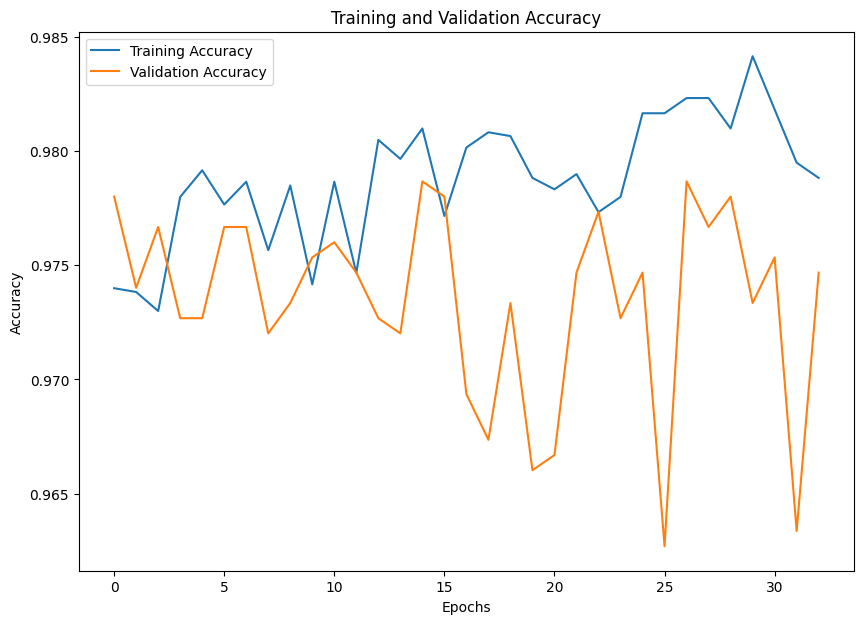

In [46]:
plt.figure(figsize=(10, 7))
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [47]:
Y_predict = model.predict(X_test)
Y_predict = np.argmax(Y_predict, axis=1)

Y_test_flat = np.argmax(Y_test, axis=1)

47/47 [==============================] - 0s 2ms/step


In [48]:
#classification report
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix



class_report = classification_report(Y_test_flat, Y_predict, target_names=speaker_folders)
print(class_report)


                   precision    recall  f1-score   support

Benjamin_Netanyau       0.94      0.99      0.97       310
 Jens_Stoltenberg       0.97      0.95      0.96       310
    Julia_Gillard       0.99      0.99      0.99       283
  Magaret_Tarcher       0.99      0.96      0.97       283
   Nelson_Mandela       1.00      1.00      1.00       315

         accuracy                           0.98      1501
        macro avg       0.98      0.98      0.98      1501
     weighted avg       0.98      0.98      0.98      1501



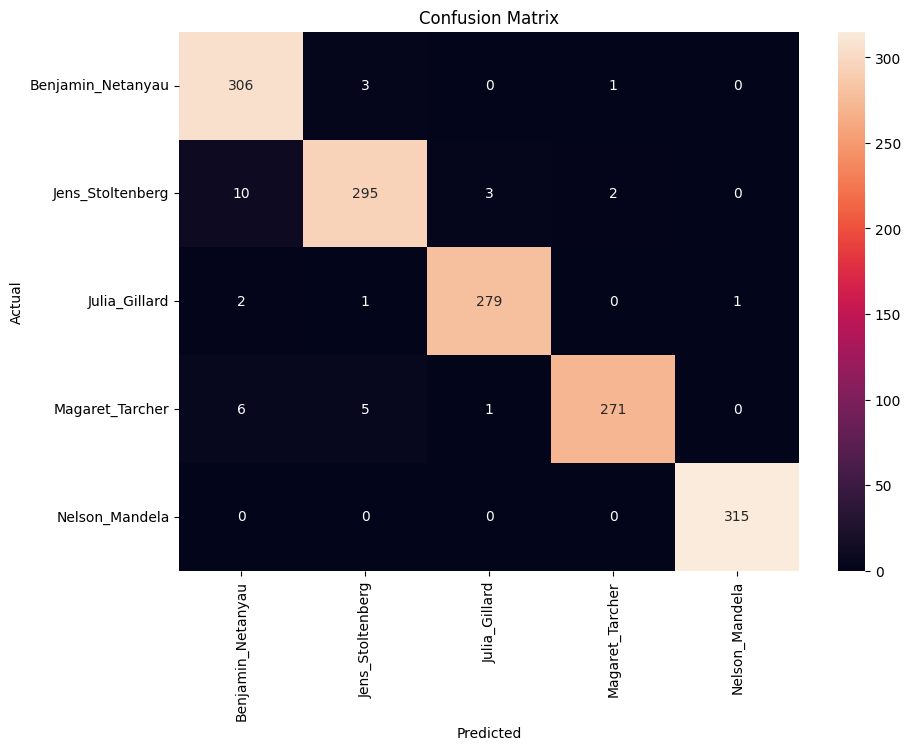

In [49]:
import seaborn as sns

plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(Y_test_flat, Y_predict), annot=True, fmt='d', xticklabels=speaker_folders, yticklabels=speaker_folders)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()